In [1]:
import numpy as np
import pandas as pd
import time

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk("input"):
    print(dirname)

input
input\evaluation
input\test
input\training


In [2]:
#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
data_path = Path('input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

In [3]:
#已解決的ID
solved_id=set()
solved_eva_id=set()

In [4]:
T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)

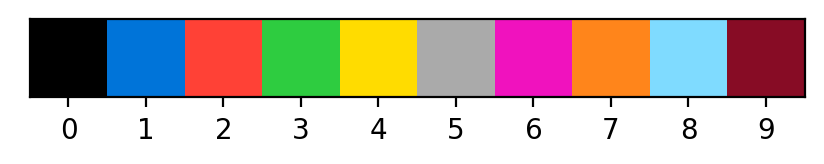

In [5]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

In [6]:

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

In [7]:
def Defensive_Copy(A): 
    if type(A)!=list:
        A=A.tolist()
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

In [8]:
def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

In [9]:
BACKGROUND=0
def _get_bound(img0):
    img=np.array(img0)
    h, w = img.shape
    x0 = w - 1
    x1 = 0
    y0 = h - 1
    y1 = 0
    for x in range(w):
        for y in range(h):
            if img[y, x] == BACKGROUND:
                continue
            x0 = min(x0, x)
            x1 = max(x1, x)
            y0 = min(y0, y)
            y1 = max(y1, y)
    return x0, x1, y0, y1
def get_bound_image(img0):
    x0,x1,y0,y1=_get_bound(img0)
    img=np.array(img0)
    return img[y0:y1+1,x0:x1+1].tolist()

In [10]:
def get_period_length0(arr):
    
    H, W = arr.shape
    period = 1
    while True:
        cycled = np.pad(arr[:period, :], ((0,H-period),(0,0)), 'wrap')
        if (cycled==arr).all():
            return period
        period += 1
def get_period_length1(arr):
    
    H, W = arr.shape
    period = 1
    while True:
        cycled = np.pad(arr[:, :period], ((0,0),(0,W-period)), 'wrap')
        if (cycled==arr).all():
            return period
        period += 1
def get_period(arr0):
    if np.sum(arr0)==0:
        return -1
#     arr_crop=get_bound_image(arr0)
#     arr=np.array(arr_crop)
    arr=np.array(arr0)
    a,b=get_period_length0(arr),get_period_length1(arr)
    period=arr[:a,:b]
    if period.shape==arr.shape:
        return -1
    return period.tolist()

In [11]:
def getObjectHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2 ** x for x in range(len(flat))])
    return np.sum(flat * mult)
#經測試沒有overflow問題
def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    return [x for x in splited if np.any(x)]
def checkColorMap(a0,b0):
    a=np.array(a0)
    b=np.array(b0)
    a[a==0]=10
    b[b==0]=10
    c = 1
    inp_hashes = sorted([getObjectHash(pm) for pm in groupByColor(a)])
    out_hashes = sorted([getObjectHash(pm) for pm in groupByColor(b)])
    c *= inp_hashes == out_hashes
    return bool(c)

def findColorMap(a,b):
    colormap = {}
    a1=np.array(a).flatten()
    b1=np.array(b).flatten()

    for col, idx in zip(*np.unique(a1,return_index=True)):
        if col in colormap.keys(): continue
        colormap[col] = b1[idx]
    return colormap
def mergedict(dict1):
    dict3={}
    for dict2 in dict1:
        for key in dict2.keys():
            if key not in dict3.keys():
                dict3[key]=dict2[key]
            elif dict3[key]!= dict2[key]:
                return False
    return dict3
def applyColorMap(pixmap, colormap):
    a1=np.array(pixmap)
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] not in colormap: #
                continue #
            a1[i][j]=colormap[pixmap[i][j]]
    return a1.tolist()

In [12]:

def Solve_return_period(basic_task): 
    # returns -1 if no match is found
    # returns Transformed_Test_Case  if the mathching rule is found
    # for this notebook we only look at mosaics
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    colormaps={}

    
        
    for x, y in zip(Input,Output):
        
        if get_period(x)==-1:
            return -1
        period_image=get_period(x)

        y_pred=period_image
        
        if checkColorMap(y_pred,y):
            colormap=findColorMap(y_pred,y)
            
            if mergedict([colormaps,colormap])==False:
                return -1
            colormaps=mergedict([colormaps,colormap])
        else:
            return -1
    if colormaps:
        period_image=get_period(Test_Case)
        
        y_pred=period_image
        y_pred_final=applyColorMap(y_pred, colormaps)
        return y_pred_final
    else:
        return -1

187 0


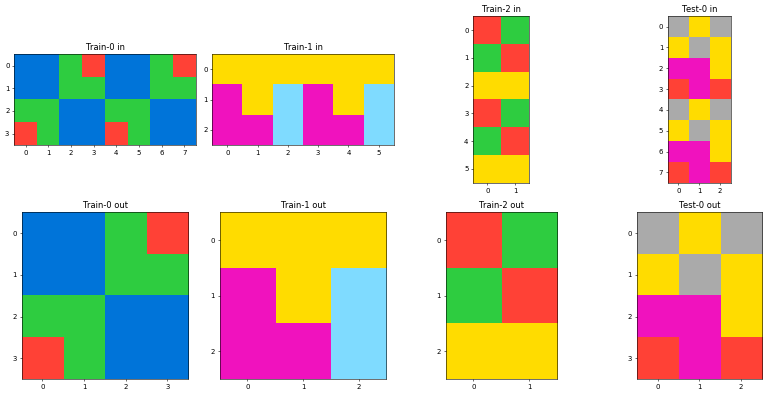

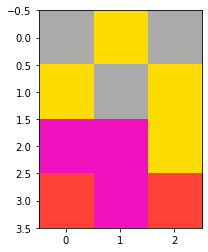

In [13]:
for i in range(400):
    task = Trains[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = Solve_return_period(basic_task)
        if proposed_solution != -1:
            print(i,j)
            solved_id.add(i)
            plot_task(task)
            
            plot_picture(proposed_solution)

In [15]:

def Solve_return_period_bound(basic_task): 
    # returns -1 if no match is found
    # returns Transformed_Test_Case  if the mathching rule is found
    # for this notebook we only look at mosaics
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    colormaps={}

    
        
    for x0, y in zip(Input,Output):
        x=get_bound_image(x0)
        if get_period(x)==-1:
            return -1
        period_image=get_period(x)

        y_pred=period_image
        
        if checkColorMap(y_pred,y):
            colormap=findColorMap(y_pred,y)
            
            if mergedict([colormaps,colormap])==False:
                return -1
            colormaps=mergedict([colormaps,colormap])
        else:
            return -1
    if colormaps:
        Test_Case=get_bound_image(Test_Case)
        period_image=get_period(Test_Case)
        
        y_pred=period_image
        y_pred_final=applyColorMap(y_pred, colormaps)
        return y_pred_final
    else:
        return -1

187 0


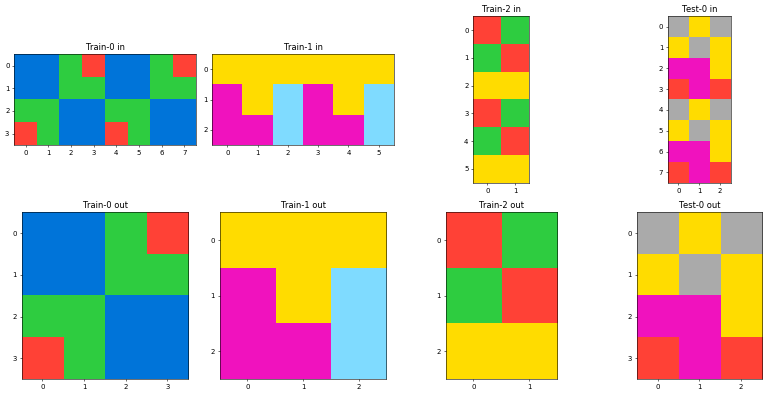

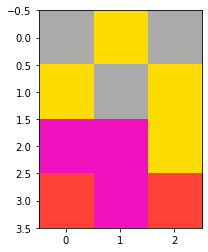

In [18]:
for i in range(400):
    task = Trains[i]
    k = len(task['test'])
    for j in range(k):
        basic_task = Create(task, j)
        proposed_solution = Solve_return_period_bound(basic_task)
        if proposed_solution != -1:
            print(i,j)
            solved_id.add(i)
            plot_task(task)
            
            plot_picture(proposed_solution)